,Datasets,Models,Metrics,Combination,Value,Rank
384,nday,gpt-3.5-turbo,#Input Token,None,1056.166667,1
387,nday,gpt-3.5-turbo,#Input Token,CWE ID,1405.236530,2
385,nday,gpt-3.5-turbo,#Input Token,CVE ID,1410.173099,3
388,nday,gpt-3.5-turbo,#Input Token,CWE Name,1414.300000,4
403,nday,gpt-3.5-turbo,#Input Token,CWE ID+CWE Name,1419.363045,5
...,...,...,...,...,...,...
1511,zeroday,gpt-3.5-turbo,Time (sec),CVE ID+CVE Description+CWE ID+CWE Description+...,19.630866,124
1459,zeroday,gpt-3.5-turbo,Time (sec),CVE Description+CWE Description+CWE Example,19.796521,125
1410,zeroday,gpt-3.5-turbo,Time (sec),CVE Description,19.870530,126
1477,zeroday,gpt-3.5-turbo,Time (sec),CVE ID+CVE Description+CWE Name+CWE Example,20.511326,127


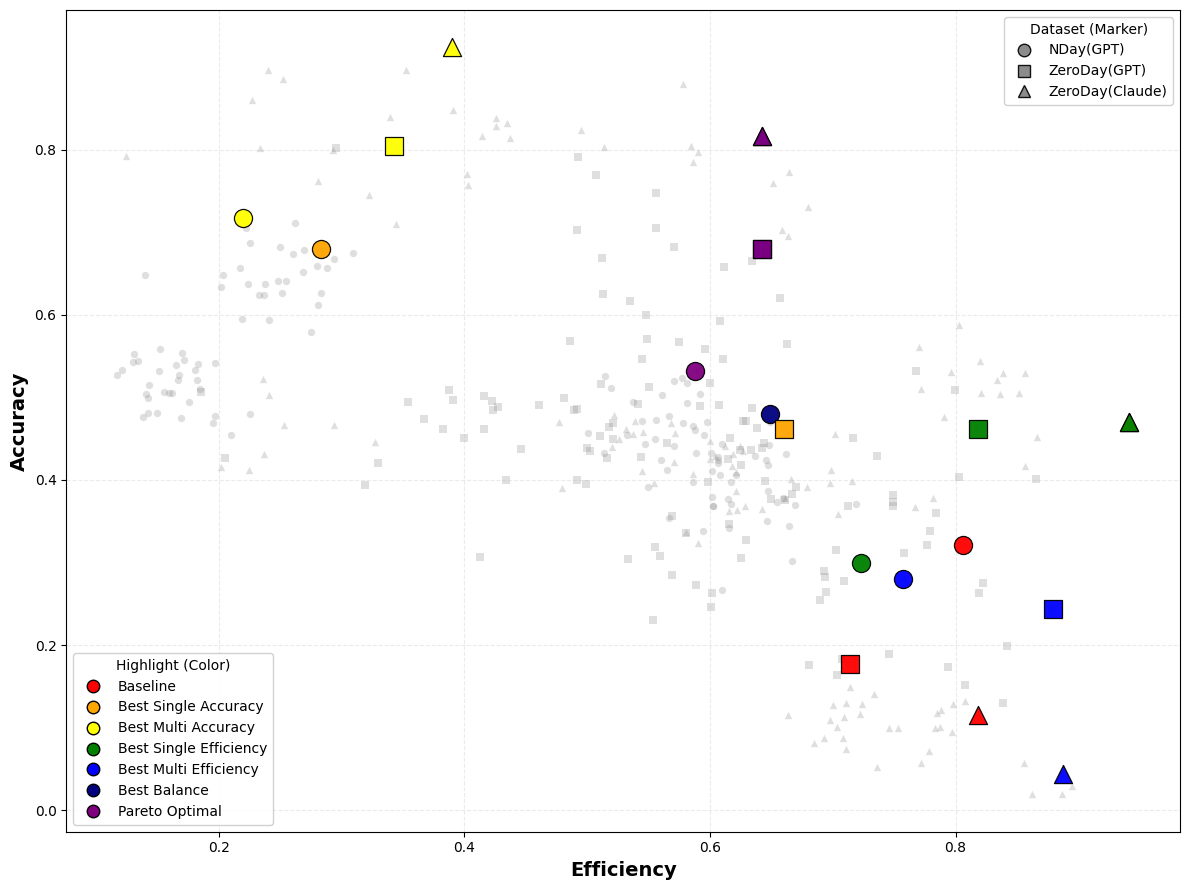

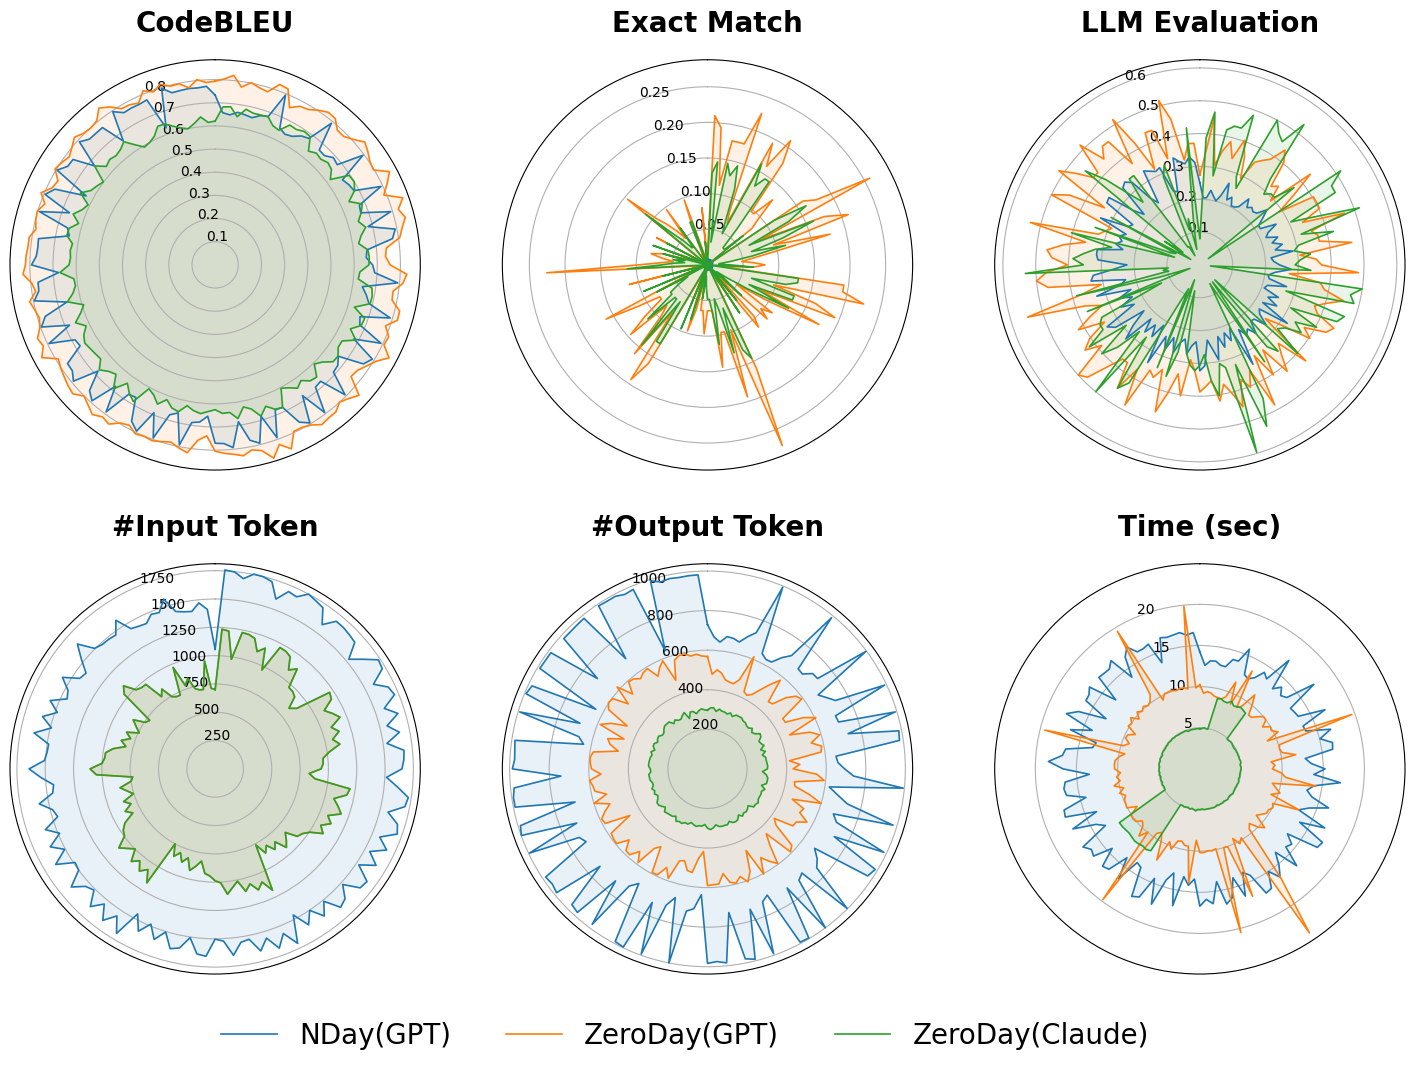

In [1]:
import os
from itertools import combinations
from math import ceil

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


results = {
    "NDay(GPT)" : "results/nday_gpt-3.5-turbo.csv",
    "ZeroDay(GPT)" : "results/zeroday_gpt-3.5-turbo.csv",
    "ZeroDay(Claude)" : "results/zeroday_claude-3-haiku-20240307.csv"
}
ELEMENTS = [
    "CVE ID","CVE Description",
    "CWE ID","CWE Name","CWE Description","CWE Example",
    "Vulnerable Lines"
]
METRICS = [
    "CodeBLEU", "Exact Match", "LLM Evaluation",
    "#Input Token", "#Output Token", "Time (sec)",
]
ACC_METRICS = METRICS[:3]
EFF_METRICS = METRICS[3:]
cols = list(range(1, 2**len(ELEMENTS) + 1))

TAG_COLOR_MAP = {
    "Baseline": "red",
    "Best Single Accuracy": "orange",
    "Best Multi Accuracy": "yellow",
    "Best Single Efficiency": "green",
    "Best Multi Efficiency": "blue",
    "Best Balance": "navy",
    "Pareto Optimal": "purple",
}
bubble_tags = list(TAG_COLOR_MAP.keys())
markers = ["o", "s", "^"]

SUBSETS = [c for r in range(len(ELEMENTS)+1) for c in combinations(ELEMENTS, r)]
IDX = {c:i+1 for i,c in enumerate(SUBSETS)}
NAME = lambda i: "None" if not SUBSETS[i-1] else "+".join(SUBSETS[i-1])


def comb_idx(x):
    s = "" if pd.isna(x) else str(x).strip()
    if not s or s == "None": return IDX[()]
    parts = tuple(p for p in (t.strip() for t in s.split("+")) if p in ELEMENTS)
    parts = tuple(sorted(set(parts), key=ELEMENTS.index))
    return IDX.get(parts, np.nan)

def ds_model(path):
    b = os.path.splitext(os.path.basename(path))[0]
    a = b.split("_", 1)
    return (a[0], a[1] if len(a) > 1 else "")

def pareto(points, acc, eff):
    pts = list(points)
    out = []
    for a in pts:
        dom = False
        for b in pts:
            if a == b: 
                continue
            if (acc[b] >= acc[a]) and (eff[b] >= eff[a]) and ((acc[b] > acc[a]) or (eff[b] > eff[a])):
                dom = True
                break
        if not dom:
            out.append(a)
    return out

def minmax(s: pd.Series) -> pd.Series:
    s = s.astype(float)
    mn, mx = s.min(), s.max()
    return pd.Series(0.5, index=s.index) if pd.isna(mn) or pd.isna(mx) or mx == mn else (s - mn) / (mx - mn)


rows = []
grouped_by_label = {}
marker_handles = []
full_factorial = pd.Series({i: len(SUBSETS[i-1]) for i in cols})
bubble_fig, bubble_ax = plt.subplots(figsize=(12, 9))
for i, (lab, path) in enumerate(results.items()):
    ds, model = ds_model(path)
    df = pd.read_csv(path, low_memory=False)
    
    df["_i"] = df["Combination"].apply(comb_idx)
    df = df.dropna(subset=["_i"]).assign(_i=lambda d: d["_i"].astype(int))
    g = df.groupby("_i")[METRICS].mean(numeric_only=True)  # index=1..128, cols=METRICS
    grouped_by_label[lab] = (ds, model, g)

    # Rankings
    for m in METRICS:
        s = g[m].dropna()
        if s.empty: 
            continue
        r = s.rank(ascending=(m in EFF_METRICS), method="min").astype(int)
        rows += [{
            "Datasets": ds, "Models": model, "Metrics": m,
            "Combination": NAME(i), "Value": float(v), "Rank": int(r[i])
        } for i, v in s.items()]
        
    # Bubbles
    marker_handles.append(
        plt.Line2D(
            [0],[0], marker=markers[i % len(markers)], linestyle="",
            markerfacecolor="gray", markeredgecolor="black", markersize=9,
            label=lab, alpha=0.9)
    )
    
    mk = markers[i % len(markers)]

    acc = pd.concat([minmax(g[m]) for m in ACC_METRICS], axis=1).mean(axis=1)
    cost = pd.concat([minmax(g[m]) for m in EFF_METRICS], axis=1).mean(axis=1)
    eff = 1.0 - cost
    bal = (acc + eff) / 2.0

    bubble_ax.scatter(eff, acc, c="gray", alpha=0.25, s=28, linewidths=0.0, marker=mk, zorder=1)
    is_none = (full_factorial.loc[g.index] == 0)
    is_single = (full_factorial.loc[g.index] == 1)
    is_multi = (full_factorial.loc[g.index] >= 2)

    def pick(mask, series, mode="max"):
        s = series[mask]
        if s.empty:
            return None
        return int(s.idxmax()) if mode == "max" else int(s.idxmin())

    none_i = int(IDX[()]) if IDX.get(()) in g.index else None
    best_single_acc = pick(is_single, acc, "max")
    best_multi_acc  = pick(is_multi,  acc, "max")
    best_single_eff = pick(is_single, eff, "max")
    best_multi_eff  = pick(is_multi,  eff, "max")
    best_balance    = pick(~is_none, bal, "max")
    pareto_set = pareto(g.index[~is_none], acc, eff)
    pareto_optimal = min(pareto_set, key=lambda c: (1-eff[c])**2 + (1-acc[c])**2)

    highlights = {
        bubble_tags[0]: none_i,
        bubble_tags[1]: best_single_acc,
        bubble_tags[2]: best_multi_acc,
        bubble_tags[3]: best_single_eff,
        bubble_tags[4]: best_multi_eff,
        bubble_tags[5]: best_balance,
        bubble_tags[6]: pareto_optimal,
    }

    for tag, idx in highlights.items():
        bubble_ax.scatter(
            [eff[idx]], [acc[idx]],
            c=TAG_COLOR_MAP[tag], s=170, edgecolors="black", linewidths=0.9,
            alpha=0.95, marker=mk, zorder=10)

# Rankings
def rankings():
    rankings = pd.DataFrame(rows).sort_values(["Datasets","Models","Metrics","Rank"], kind="mergesort")
    rankings.to_csv("results/rankings.csv", index=False)
    display(rankings)

# Bubbles
def bubbles():
    bubble_ax.set_xlabel("Efficiency", fontsize=14, fontweight="bold")
    bubble_ax.set_ylabel("Accuracy", fontsize=14, fontweight="bold")
    bubble_ax.grid(True, linestyle="--", alpha=0.25)

    tag_handles = [
        plt.Line2D(
            [0],[0], marker="o", linestyle="",
            markerfacecolor=c, markeredgecolor="black", markersize=9, label=t)
        for t, c in TAG_COLOR_MAP.items()
    ]
    leg1 = bubble_ax.legend(
        handles=marker_handles, loc="upper right", frameon=True, framealpha=0.9,
        title="Dataset (Marker)")
    bubble_ax.add_artist(leg1)
    bubble_ax.legend(
        handles=tag_handles, loc="lower left", frameon=True, framealpha=0.9,
        title="Highlight (Color)")

    bubble_fig.tight_layout()
    bubble_fig.savefig("results/bubbles.png", dpi=300, bbox_inches="tight")
    plt.show()
    plt.close(bubble_fig)

# Radar
def radar():
    ncols = 3
    n = len(METRICS)
    nrows = ceil(n / ncols)
    radar_fig, axes = plt.subplots(nrows, ncols, subplot_kw={"polar": True}, figsize=(18, 12))
    axes = np.array(axes).reshape(-1)
    labels = list(results.keys())
    angles = np.linspace(0, 2*np.pi, len(cols), endpoint=False)
    angles_c = np.r_[angles, angles[0]]
    metric_frames = {
        m: pd.DataFrame({lab: grouped_by_label[lab][2][m] for lab in labels}).T.reindex(columns=cols)
        for m in METRICS
    }
    legend_handles = None
    legend_labels = None
    for i, m in enumerate(METRICS):
        ax = axes[i]
        ax.set_theta_zero_location("N")
        ax.set_xticks([])
        handles = []
        for lab in labels:
            v = metric_frames[m].loc[lab].astype(float).fillna(0.0).values
            v_c = np.r_[v, v[0]]
            (ln,) = ax.plot(angles_c, v_c, linewidth=1.2, label=lab)
            ax.fill(angles_c, v_c, alpha=0.10)
            handles.append(ln)
        ax.set_title(m, fontsize=20, fontweight="bold", pad=20)
        if i == 0:
            legend_handles, legend_labels = handles, labels
    radar_fig.legend(
        legend_handles, legend_labels,
        loc="lower center", ncol=len(labels),
        frameon=False, bbox_to_anchor=(0.5, 0.03),
        fontsize=20
    )
    radar_fig.savefig("results/radar.png", dpi=300, bbox_inches="tight")
    plt.show()
    plt.close(radar_fig)


if __name__ == "__main__":
    rankings()
    bubbles()
    radar()

In [ ]:
import pandas as pd
import numpy as np

CSV_PATH = "results/nday_gpt-3.5-turbo.csv"
NONE = "None"

ACC_METRICS = ["CodeBLEU", "Exact Match", "LLM Evaluation"]
EFF_METRICS = ["#Input Token", "#Output Token", "Time (sec)"]


# --- utils (짧게) ---
def bool01(x) -> int:
    if isinstance(x, bool): return int(x)
    if isinstance(x, str):
        v = x.strip().lower()
        return 1 if v in {"true", "1", "yes"} else 0 if v in {"false", "0", "no"} else 0
    if isinstance(x, (int, float)) and not pd.isna(x): return int(x)
    return 0

def comb_clean(x) -> str:
    s = "" if pd.isna(x) else str(x).strip()
    return NONE if (not s or s.lower() == "none") else s

def minmax(s: pd.Series) -> pd.Series:
    s = s.astype(float)
    mn, mx = s.min(), s.max()
    return pd.Series(0.5, index=s.index) if mx == mn else (s - mn) / (mx - mn)

def split_elems(comb: str):
    s = str(comb).strip()
    if not s or s == NONE: return []
    return [p for p in (t.strip() for t in s.split("+")) if p and p != NONE]

def best(scores: pd.Series, mask: pd.Series, want_max=True):
    s = scores[mask]
    return None if s.empty else (s.idxmax() if want_max else s.idxmin())

def element_stats(target: pd.DataFrame, base: float, col: str, title: str):
    if target.empty: return None
    els = set().union(*map(split_elems, target.index))
    rows = []
    idx_series = target.index.to_series()
    for el in els:
        m = idx_series.apply(lambda x: el in split_elems(x))
        if m.any():
            avg = target.loc[m, col].mean()
            rows.append({"Element": el, "Count": int(m.sum()), f"Avg {title}": avg,
                         "Avg Lift": avg - base, "Avg Loss": base - avg})
    return pd.DataFrame(rows).sort_values(f"Avg {title}", ascending=False) if rows else None

def pareto_optimal(items, acc: pd.Series, eff: pd.Series):
    it = list(items)
    out = []
    for a in it:
        if any((b != a) and (acc[b] >= acc[a]) and (eff[b] >= eff[a]) and ((acc[b] > acc[a]) or (eff[b] > eff[a]))
               for b in it):
            continue
        out.append(a)
    return out

def print_acc_block(summary, scores, is_none, is_single, is_multi):
    print("\n" + "=" * 80)
    print("1. Accuracy (CodeBLEU + Exact Match + LLM Evaluation)")
    print("=" * 80)

    def show(c):
        print(f"  Combination:    {c}")
        print(f"  CodeBLEU:       {summary.loc[c, 'CodeBLEU']:.3f}")
        print(f"  Exact Match:    {summary.loc[c, 'Exact Match']:.3f}")
        print(f"  LLM Evaluation: {summary.loc[c, 'LLM Evaluation']:.3f}")
        print(f"  Accuracy avg:   {scores.loc[c, 'acc_score']:.3f}")

    print("\n[1-1] None averages"); show(NONE)

    print("\n[1-2] Best single by accuracy")
    b = best(scores["acc_score"], is_single, True)
    if b: show(b)

    print("\n[1-3] Best multiple by accuracy")
    b = best(scores["acc_score"], is_multi, True)
    if b: show(b)

    print("\n[1-4] Compared to None (accuracy)")
    base = scores.loc[NONE, "acc_score"]
    worse = scores[(~is_none) & (scores["acc_score"] < base)]
    better = scores[(~is_none) & (scores["acc_score"] > base)]

    print(f"\n[Better than None] Total combinations: {len(better)}")
    st = element_stats(better, base, "acc_score", "Acc")
    if st is not None:
        print(f"{'Element':<25} | {'Count':<6} | {'Avg Acc':<10} | {'Avg Lift':<10}")
        print("-" * 65)
        for _, r in st.iterrows():
            print(f"{r['Element']:<25} | {int(r['Count']):<6} | {r['Avg Acc']:>10.4f} | {r['Avg Lift']:>10.4f}")

    print(f"\n[Worse than None] Total combinations: {len(worse)}")
    st = element_stats(worse, base, "acc_score", "Acc")
    if st is not None:
        st = st.sort_values("Avg Acc", ascending=True)
        print(f"{'Element':<25} | {'Count':<6} | {'Avg Acc':<10} | {'Avg Loss':<10}")
        print("-" * 65)
        for _, r in st.iterrows():
            print(f"{r['Element']:<25} | {int(r['Count']):<6} | {r['Avg Acc']:>10.4f} | {r['Avg Loss']:>10.4f}")

def print_eff_block(summary, scores, is_none, is_single, is_multi):
    print("\n" + "=" * 80)
    print("2. Efficiency (#Input Token + #Output Token + Time)")
    print("=" * 80)

    def show(c):
        print(f"  Combination:    {c}")
        print(f"  #Input Token:   {summary.loc[c, '#Input Token']:.0f}")
        print(f"  #Output Token:  {summary.loc[c, '#Output Token']:.0f}")
        print(f"  Time (sec):     {summary.loc[c, 'Time (sec)']:.2f}")
        print(f"  Efficiency avg: {scores.loc[c, 'eff_inv']:.3f}")

    print("\n[2-1] None averages"); show(NONE)

    print("\n[2-2] Best single by efficiency (min score)")
    b = best(scores["eff_score"], is_single, False)
    if b: show(b)

    print("\n[2-3] Best multiple by efficiency (min score)")
    b = best(scores["eff_score"], is_multi, False)
    if b: show(b)

    print("\n[2-4] Compared to None (efficiency)")
    base = scores.loc[NONE, "eff_inv"]
    worse = scores[(~is_none) & (scores["eff_inv"] < base)]
    better = scores[(~is_none) & (scores["eff_inv"] > base)]

    print(f"\n[Better than None] Total combinations: {len(better)}")
    st = element_stats(better, base, "eff_inv", "Eff")
    if st is not None:
        print(f"{'Element':<25} | {'Count':<6} | {'Avg Eff':<10} | {'Avg Lift':<10}")
        print("-" * 65)
        for _, r in st.iterrows():
            print(f"{r['Element']:<25} | {int(r['Count']):<6} | {r['Avg Eff']:>10.4f} | {r['Avg Lift']:>10.4f}")

    print(f"\n[Worse than None] Total combinations: {len(worse)}")
    st = element_stats(worse, base, "eff_inv", "Eff")
    if st is not None:
        st = st.sort_values("Avg Eff", ascending=True)
        print(f"{'Element':<25} | {'Count':<6} | {'Avg Eff':<10} | {'Avg Loss':<10}")
        print("-" * 65)
        for _, r in st.iterrows():
            print(f"{r['Element']:<25} | {int(r['Count']):<6} | {r['Avg Eff']:>10.4f} | {r['Avg Loss']:>10.4f}")

def print_tradeoff(summary, scores, is_none):
    print("\n" + "=" * 80)
    print("3. Trade-off (Accuracy vs Efficiency)")
    print("=" * 80)

    print("\n[3-1] Best balance score")
    cand = scores[~is_none].sort_values("balance", ascending=False)
    if not cand.empty:
        top = cand.index[0]
        print(f"  Combination: {top}")
        print(f"  Accuracy avg: {scores.loc[top, 'acc_score']:.3f} (CodeBLEU={summary.loc[top, 'CodeBLEU']:.3f}, Exact Match={summary.loc[top, 'Exact Match']:.3f}, LLM Eval={summary.loc[top, 'LLM Evaluation']:.3f})")
        print(f"  Efficiency avg: {scores.loc[top, 'eff_inv']:.3f}  (in={summary.loc[top, '#Input Token']:.0f}, out={summary.loc[top, '#Output Token']:.0f}, time={summary.loc[top, 'Time (sec)']:.2f}s)")

    print("\n[3-2] Pareto optimal (show top-1 by accuracy)")
    combos = scores.index[~is_none]
    pareto = pareto_optimal(combos, scores["acc_score"], scores["eff_inv"])
    pareto_top = min(
        pareto,
        key=lambda c: (1 - scores.loc[c, "eff_inv"])**2 + (1 - scores.loc[c, "acc_score"])**2
    )
    if pareto_top:
        top = pareto_top
        print(f"  Top: {top}")
        print(f"  Accuracy avg: {scores.loc[top, 'acc_score']:.3f} (CodeBLEU={summary.loc[top, 'CodeBLEU']:.3f}, Exact Match={summary.loc[top, 'Exact Match']:.3f}, LLM Eval={summary.loc[top, 'LLM Evaluation']:.3f})")
        print(f"  Efficiency avg: {scores.loc[top, 'eff_inv']:.3f}  (in={summary.loc[top, '#Input Token']:.0f}, out={summary.loc[top, '#Output Token']:.0f}, time={summary.loc[top, 'Time (sec)']:.2f}s)")

if __name__ == "__main__":
    df = pd.read_csv(CSV_PATH, low_memory=False)
    df["Combination"] = df["Combination"].apply(comb_clean)
    df["Exact Match"] = df["Exact Match"].apply(bool01)
    df["LLM Evaluation"] = df["LLM Evaluation"].apply(bool01)

    summary = df.groupby("Combination")[ACC_METRICS + EFF_METRICS].mean()
    if NONE not in summary.index:
        summary.loc[NONE] = np.nan

    norm_acc = pd.DataFrame({m: minmax(summary[m]) for m in ACC_METRICS})
    norm_eff = pd.DataFrame({m: minmax(summary[m]) for m in EFF_METRICS})

    scores = pd.DataFrame(index=summary.index)
    scores["acc_score"] = norm_acc.mean(axis=1)
    scores["eff_score"] = norm_eff.mean(axis=1)   # lower is better
    scores["eff_inv"] = 1 - scores["eff_score"]   # higher is better
    scores["balance"] = scores["acc_score"] + scores["eff_inv"]

    idx = scores.index.to_series()
    is_none = idx.eq(NONE)
    is_multi = (~is_none) & idx.str.contains(r"\+")
    is_single = (~is_none) & (~idx.str.contains(r"\+"))

    print("=" * 80)
    print("Experiment Result Analysis")
    print("=" * 80)
    print(f"\nTotal rows: {len(df)}")
    print(f"  - None rows: {int((df['Combination'] == NONE).sum())}")
    print(f"  - Single rows: {int(((df['Combination'] != NONE) & (~df['Combination'].str.contains(r'\+'))).sum())}")
    print(f"  - Multiple rows: {int(((df['Combination'] != NONE) & (df['Combination'].str.contains(r'\+'))).sum())}")

    print_acc_block(summary, scores, is_none, is_single, is_multi)
    print_eff_block(summary, scores, is_none, is_single, is_multi)
    print_tradeoff(summary, scores, is_none)
